In [27]:
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
import torch
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
from umap import UMAP
from sklearn.decomposition import KernelPCA
from sklearn.manifold import LocallyLinearEmbedding
import matplotlib.pyplot as plt

In [4]:
model_name = "rv2307/electra-small-ner"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
dataset = load_dataset("creativeautomaton/wikidata_rdf_massive_objects_EN-triples-and-sentences", split="train").to_pandas()

Repo card metadata block was not found. Setting CardData to empty.
Generating train split: 100%|██████████| 12527963/12527963 [00:21<00:00, 591711.48 examples/s]


In [6]:
false_dataset = dataset.copy()
false_dataset["relation"] = false_dataset["relation"].apply(lambda s: "NOT " + s)


In [ ]:
good_embeddings = []
for batch in tqdm(range(0, 512, 256)):

    batch_triples = dataset.loc[batch:batch+256, ["head", "relation", "tail"]].values.tolist()
    encodings = tokenizer(batch_triples, padding=True, truncation=True, is_split_into_words=True, return_tensors="pt")
    outputs = model(**encodings.to("cuda" if torch.cuda.is_available() else "cpu"))
    batch_embeddings = outputs.last_hidden_state
    word_embeddings = [torch.stack([batch_embeddings[i, encoding.word_to_tokens(w), :].mean(dim=0) for w in range(3)]) for i,encoding in enumerate(encodings.encodings)]
    good_embeddings.append(torch.stack(word_embeddings))

good_embeddings = torch.cat(good_embeddings, dim=0)

100%|██████████| 2/2 [00:15<00:00,  7.83s/it]


In [12]:
bad_embeddings = []
for batch in tqdm(range(0, 512, 256)):

    batch_triples = false_dataset.loc[batch:batch+256, ["head", "relation", "tail"]].values.tolist()
    encodings = tokenizer(batch_triples, padding=True, truncation=True, is_split_into_words=True, return_tensors="pt")
    outputs = model(**encodings.to("cuda" if torch.cuda.is_available() else "cpu"))
    batch_embeddings = outputs.last_hidden_state
    word_embeddings = [torch.stack([batch_embeddings[i, encoding.word_to_tokens(w), :].mean(dim=0) for w in range(3)]) for i,encoding in enumerate(encodings.encodings)]
    bad_embeddings.append(torch.stack(word_embeddings))

bad_embeddings = torch.cat(bad_embeddings, dim=0)

100%|██████████| 2/2 [00:14<00:00,  7.33s/it]


In [ ]:
n_neighbors = 6 # 6 is the minimum for the Hessian method


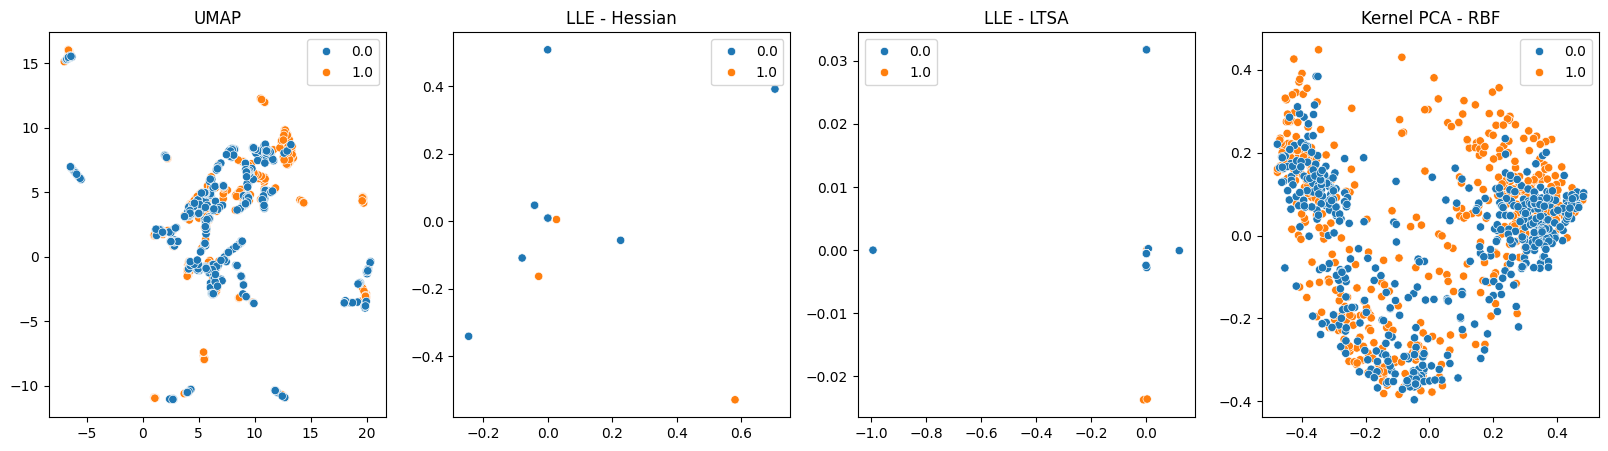

In [33]:
#sentence plot
sentence_embeddings = torch.cat([good_embeddings, bad_embeddings], dim=0).detach().numpy().mean(axis = 1)
umap_data = UMAP(n_components=2, n_neighbors = n_neighbors).fit_transform(sentence_embeddings)
lle_data = LocallyLinearEmbedding(n_components=2, method = 'hessian', n_neighbors = n_neighbors, eigen_solver = 'dense').fit_transform(sentence_embeddings)
ltsa_data = LocallyLinearEmbedding(n_components=2, method = 'ltsa', n_neighbors = n_neighbors, eigen_solver = 'dense').fit_transform(sentence_embeddings)
kernel_pca_data = KernelPCA(n_components=2, kernel="rbf").fit_transform(sentence_embeddings)

f, ax = plt.subplots(1, 4, figsize = (20, 5))
sns.scatterplot(x = umap_data[:,0], y = umap_data[:,1], hue = np.concatenate([np.ones(len(good_embeddings)), np.zeros(len(bad_embeddings))]), ax = ax[0])
ax[0].set_title("UMAP")
sns.scatterplot(x = lle_data[:,0], y = lle_data[:,1], hue = np.concatenate([np.ones(len(good_embeddings)), np.zeros(len(bad_embeddings))]), ax = ax[1])
ax[1].set_title("LLE - Hessian")
sns.scatterplot(x = ltsa_data[:,0], y = ltsa_data[:,1], hue = np.concatenate([np.ones(len(good_embeddings)), np.zeros(len(bad_embeddings))]), ax = ax[2])
ax[2].set_title("LLE - LTSA")
sns.scatterplot(x = kernel_pca_data[:,0], y = kernel_pca_data[:,1], hue = np.concatenate([np.ones(len(good_embeddings)), np.zeros(len(bad_embeddings))]), ax = ax[3])
ax[3].set_title("Kernel PCA - RBF")
plt.show()



ValueError: All arrays must be of the same length

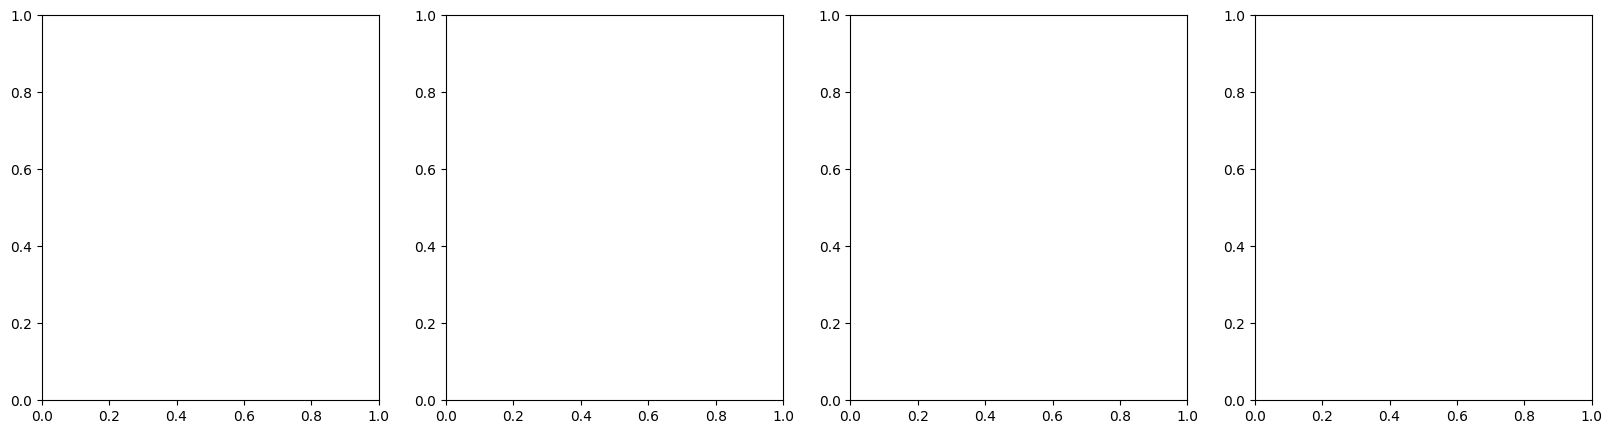

In [ ]:
entity_rel_embeddings = torch.flatten(torch.cat([good_embeddings, bad_embeddings], dim=0), end_dim = 1).detach().numpy()

umap_data = UMAP(n_components=2, n_neighbors = n_neighbors).fit_transform(entity_rel_embeddings)
lle_data = LocallyLinearEmbedding(n_components=2, method = 'hessian', n_neighbors = n_neighbors, eigen_solver = 'dense').fit_transform(entity_rel_embeddings)
ltsa_data = LocallyLinearEmbedding(n_components=2, method = 'ltsa', n_neighbors = n_neighbors, eigen_solver = 'dense').fit_transform(entity_rel_embeddings)
kernel_pca_data = KernelPCA(n_components=2, kernel="rbf").fit_transform(entity_rel_embeddings)

f, ax = plt.subplots(1, 4, figsize = (20, 5))
sns.scatterplot(x = umap_data[:,0], y = umap_data[:,1], hue = np.concatenate([np.ones(len(good_embeddings)*3), np.zeros(len(bad_embeddings)*3)]), style = [0,1,2]*(len(entity_rel_embeddings)//3), ax = ax[0])
ax[0].set_title("UMAP")
sns.scatterplot(x = lle_data[:,0], y = lle_data[:,1], hue = np.concatenate([np.ones(len(good_embeddings)*3), np.zeros(len(bad_embeddings)*3)]), style = [0,1,2]*(len(entity_rel_embeddings)//3), ax = ax[1])
ax[1].set_title("LLE - Hessian")
sns.scatterplot(x = ltsa_data[:,0], y = ltsa_data[:,1], hue = np.concatenate([np.ones(len(good_embeddings)*3), np.zeros(len(bad_embeddings)*3)]), style = [0,1,2]*(len(entity_rel_embeddings)//3), ax = ax[2])
ax[2].set_title("LLE - LTSA")
sns.scatterplot(x = kernel_pca_data[:,0], y = kernel_pca_data[:,1], hue = np.concatenate([np.ones(len(good_embeddings)*3), np.zeros(len(bad_embeddings)*3)]), style = [0,1,2]*(len(entity_rel_embeddings)//3), ax = ax[3])
ax[3].set_title("Kernel PCA - RBF")
plt.show()

In [ ]:
good_embeddings - bad_embeddings